# Import necessary libraries first.
   ## torch contains the main model-related functions
   ## matplotlib for plotting
   ## torchsummary for summarizing the models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.optim as optim

In [2]:
device = "cuda:0"

# We are going implement a simple multilayer perceptron (MLP)
## Generate data first

In [3]:
# Generate the ground truth data first
# We will generate Bernoulli samples with p = 0.5, size = [1000, 2]
num_samples = 10000
p = 0.5; size = [num_samples, 2]
x = torch.bernoulli(p * torch.ones(size))
# Convert to integers to generate XOR labels
x = x.int()
# print(x.shape)


# The labels are generated by taking an XOR of the elements of the data
y = x[:, 0] ^ x[:, 1]
y = y.float()
print(y.shape)
y = y.unsqueeze(-1)
print(y.shape)

# Change input type back to float
x = x.float()
# Perturb the input
mean = 0
std = 0.001
x = x + std * torch.randn(x.size()) + mean
print(x)
print(y)


torch.Size([10000])
torch.Size([10000, 1])
tensor([[-9.3069e-04,  1.4001e-03],
        [ 9.9921e-01,  9.9906e-01],
        [ 3.1747e-04, -1.3946e-03],
        ...,
        [ 9.9986e-01,  9.9968e-01],
        [ 1.0019e+00,  8.4672e-04],
        [-1.2180e-03,  1.0004e+00]])
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]])


## Now define the model

In [4]:
# The ANN has one input layer (2 nodes), one hidden layer (2 nodes), and one output node (1 node)
class ANN(nn.Module):

     def __init__(self):
          super(ANN, self).__init__()
          # Hidden layer
          self.fc1 = nn.Linear(2, 2)
          # Output layer
          self.fc2 = nn.Linear(2, 1)

     def forward(self, input):
          # Find the output of the hidden layer 
          nl1 = F.relu(self.fc1(input))
          # Find the output of the output layer
          nl2 = F.relu(self.fc2(nl1))
          output = nl2
          # Return the output of the output layer
          output = output.float()
          return output

## Create an instance of the model

In [5]:
# Create an instance of the ANN        
ann = ANN()     
ann.to(device)
# The summary function expects the input size as the second argument
summary(ann, (1, 2))
print(ann)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 2]               6
            Linear-2                 [-1, 1, 1]               3
Total params: 9
Trainable params: 9
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
ANN(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)


## Define the loss function

In [6]:
# Let's use the MSE loss
criterion = nn.MSELoss()

# Initialize the optimizer
optimizer = optim.SGD(ann.parameters(), lr=0.1, momentum=0.9)

## Now train the model

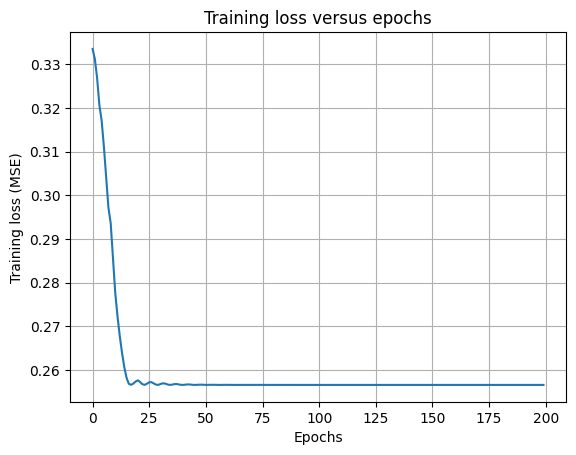

In [7]:
# Denote x as inputs and y as labels
inputs = x; labels = y
# Set epoch count to 1000
num_epochs = 200
# Set batch size to 500
batch_size = num_samples
# Batch count = num_samples/batch_size
batch_count = (int)(num_samples/batch_size)
# Save training loss values
loss_values = torch.zeros([num_epochs], dtype=float)
      
# Pass the entire dataset through the model num_epoch times
for epoch in range(num_epochs):  # loop over the dataset multiple times
    for count in range(batch_count):
        # Initliaze running loss to zero
        running_loss = 0.0
        batch_input = inputs[count*batch_size:(count + 1)*batch_size,:]
        batch_labels = labels[count*batch_size:(count + 1)*batch_size]

        # to device
        batch_input = batch_input.to(device)
        batch_labels = batch_labels.to(device)

        # forward + backward + optimize
        outputs = ann(batch_input)
        # Compute loss
        loss = criterion(outputs, batch_labels)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Backprop loss
        loss.backward()
        # Update model parameters
        optimizer.step()

        # Update loss and print statistics
        running_loss += loss.item()
    loss_values[epoch] = running_loss
    # print(f'loss: {running_loss}')

# print('Finished Training')
plt.plot(loss_values.numpy())
plt.title('Training loss versus epochs')
plt.xlabel('Epochs')
plt.ylabel('Training loss (MSE)')
plt.grid()
plt.show()

## Validate the model

In [10]:
# Generate five random test samples
test = torch.bernoulli(p * torch.ones([5, 2]))
# test = test.int()
test = test.float()
# Perturb the test input
test = test + std * torch.randn(test.size()) + mean
test = test.to(device)

# Predict the output using the trained ANN
test_output = ann(test)
print(test)
print(test_output)

tensor([[-8.5515e-04,  2.2369e-04],
        [ 1.0016e+00,  3.4591e-04],
        [-2.8507e-04,  5.3877e-04],
        [ 4.9573e-05,  8.2057e-04],
        [-9.0975e-04, -1.5261e-03]], device='cuda:0')
tensor([[0.0000],
        [1.0019],
        [0.0000],
        [0.0000],
        [0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)


## Print the model parameter values

In [11]:
# Loop over the parameters
for name, param in ann.named_parameters():
    if param.requires_grad:
        print (name, param.data)

fc1.weight tensor([[-0.9550,  0.9421],
        [-0.1159, -0.5935]], device='cuda:0')
fc1.bias tensor([ 1.0759, -0.1677], device='cuda:0')
fc2.weight tensor([[-1.6259,  0.0960]], device='cuda:0')
fc2.bias tensor([1.1966], device='cuda:0')
